In [28]:
#matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Polynomial regression - LS vs MLE

### Selecting model-order and Generating data
Here we will generate a synthetic dataset from a n-th order polynomial model **$y = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n $** and add some noise, with known distribution, to simulate sampling of the data, giving us **$y_{measured} = y + noise$**,  where:  
$y$ = output  
$u$ = input    
$\theta_{0,1,...,n}$ = model parameters   
$noise$ = measurement noise

Given the genreated input data $u$ and the measured data **$y_{measured}$** we will try to estimate the polynomial model coeffitienst $\hat{\theta}_{0,1,...,n}$ using the Least sqaures (LS) and Maximum likelihood estimate (MLE) methods.

### Model-order selection 
The "params" vector decides the order of the selected model, make sure to put in \$n+1\$ parameters into the vector for the get a model of order \$n\$, the first parameter \$\theta_0\$ is the bias term

Text(0.5, 1.0, 'Model')

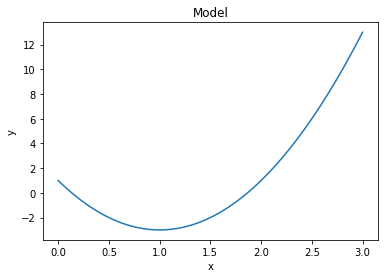

In [29]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model

# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = [1,-8,4]
y_model = arbitrary_poly(true_params)

# Plot true model
x = np.linspace(start=0, stop=3, num=100)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model")


### Measurement noise generation from a chosen distribution
Probability density functions (PDFs):

Gaussian pdf: $P(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

Laplacian pdf: $P(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}$

Hyperparameters to adjust:
- dist: "laplace" or "gauss" : the class of noise-generating distribution.
- mu: The distribution's location parameter (mean value for Gauss).
- sigma: The distribution's scaling parameter (std. for Gauss).
- magnitude: The noise magnitude.
- N: number of samples to generate for the model.

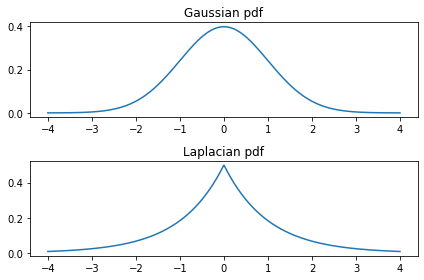

In [30]:
# Hyperparameters for the type of noise-generating distribution.
dist = "gauss"  # choose between "laplace" or "gauss"
loc = 0           # location (mean) parameter 
scale = 1         # scaling (std dev) parameter
magnitude = 1.2   # noise magnitude
N = 20           # number of samples

np.random.seed(123)  # Non-random generation between code executions. Comment out for true random

# The Laplace probability density function:
# Also available in library "scipy.stats.laplace"
def laplace_pdf(x, loc, scale):
    return (1.0/(2.0 * scale)) * np.exp( -np.abs(x-loc) / scale)

# The Gaussian probability density function:
# Also available in library "scipy.stats.norm"
def gauss_pdf(x, loc, scale):
    return 1.0/(scale * np.sqrt(2.0 * np.pi)) * np.exp( -0.5 * ((x - loc) / scale)**2 )

# Plot pdfs:
fig, [ax0, ax1] = plt.subplots(2)

n = np.linspace(start=(loc - 4*scale), stop=(loc + 4*scale), num=1000)  # input range centered around mean of pdf
ax0.plot(n, gauss_pdf(n, loc, scale))
ax0.set_title('Gaussian pdf')
ax1.plot(n,laplace_pdf(n, loc, scale))
ax1.set_title('Laplacian pdf')
plt.tight_layout()
plt.show()

### Data generation:

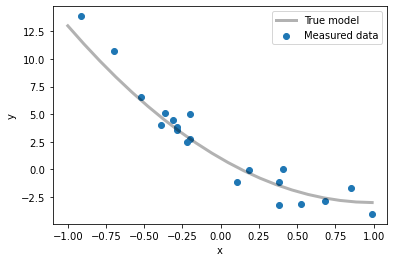

In [46]:
# Generate data points
range_low = -1
range_high = 1
u = np.sort(np.random.uniform(range_low,range_high,N))
y_true = y_model(u)
# Generate noise
"""
from scipy.stats import norm, laplace
if dist == "laplace":
    #pdf = laplace.pdf
    noise = magnitude * np.random.laplace(loc, scale, N)
elif dist == "gauss":
    #pdf = norm.pdf
    noise = magnitude * np.random.normal(loc, scale, N)
else:
    raise Exception("Distribution not implemented, choose \"laplace\" or \"gauss\"")

"""
# Add noise to the generated data points - thus simulating measurement
def plot_measurments(alpha):
    u0 = np.linspace(-1, max(u), N)
    #alpha = 1.0
    noise =alpha* magnitude * np.random.normal(loc, scale, N) + (1-alpha)*magnitude * np.random.laplace(loc,scale, N)

    y = y_true + noise
    # Plot measured data
    plt.scatter(u, y, label=r"Measured data")
    plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y")
plot_measurments(0.5)



## Least squares regression - LS
### Given the sampled data we can estimate the underlying polynomial model using LS regression
Solution to a least squares problem is given by the normal equation:  
$\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$

### Step 1 - rewrite the model in matrix form to get the data tensor u
$y_{measured} = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n  + noise =   [1 \; u^1 \; .. \; u^n] \cdot [ \theta_0 \; \theta_1 \; .. \; \theta_n ] ^T + noise$

$\mathbf{u} = [1 \; u^1 \; .. \; u^n]$

In [32]:
# Matrix form
u_tensor_0 = np.reshape(u,(N,1))
print(f"data u :\n{u_tensor_0[0:5]} \n")

ones_vec = np.ones((N,1))
u_tensor = np.append(ones_vec, u_tensor_0, axis=1)

for i in range(2,len(true_params)):
    u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)

print(f"data tensor [1, u, u^2, ... , u^n] :\n{u_tensor[0:5,:]}")


data u :
[[-0.88064421]
 [-0.64909649]
 [-0.63501654]
 [-0.54629709]
 [-0.42772133]] 

data tensor [1, u, u^2, ... , u^n] :
[[ 1.         -0.88064421  0.77553422]
 [ 1.         -0.64909649  0.42132625]
 [ 1.         -0.63501654  0.403246  ]
 [ 1.         -0.54629709  0.29844051]
 [ 1.         -0.42772133  0.18294554]]


### Step 2   

calculate $(\mathbf{u}^T \cdot \mathbf{u})^{-1}$

In [33]:
u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
print(u_transpose_dot_u_inv)


u_transpose_dot_y = np.dot(u_tensor.T,y)  # calculating dot product
print(u_transpose_dot_y)


[[ 0.08545074  0.00881834 -0.16815014]
 [ 0.00881834  0.24194317  0.00761967]
 [-0.16815014  0.00761967  0.80776879]]
[ 39.20351733 -37.7950023   16.67811447]


### Step 3  

calculate $(\mathbf{u}^T \cdot \mathbf{y})$

In [34]:
u_transpose_dot_y = np.dot(u_tensor.T,y)  # calculating dot product
print(u_transpose_dot_y)

[ 39.20351733 -37.7950023   16.67811447]


### Step 4 

solve for $\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$

LS parameters:         ['0.21', '-8.67', '6.59']
True model parameters: [1, -8, 4]


Text(0, 0.5, 'y')

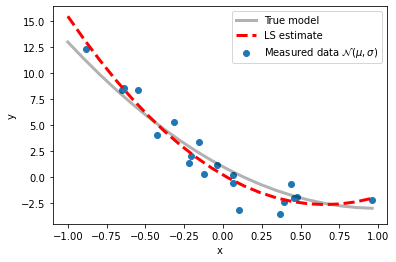

In [38]:
LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
LS_params_vector = LS_params
LS_params_rounded = ["{:.2f}".format(round(i, 2)) for i in LS_params.tolist()]
print(f"LS parameters:         {LS_params_rounded}")
print(f"True model parameters: {true_params}")



# Recreate model based on LS estimate:
LS_params = LS_params.tolist()
LS_estimate = arbitrary_poly(LS_params)

# Plot true vs. estimated model
plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
u0 = np.linspace(-1, max(u), N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.plot(u0, LS_estimate(u0), "r--",  lw=3, label="LS estimate")
#plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

calculating the e Euclidean distance d

In [43]:
diff = np.array(true_params) - LS_params_vector
distance = np.linalg.norm(diff)
print(distance)

[ 0.78774679  0.67145114 -2.5919981 ]
2.7910295195115005


The plot for $\alpha$ = 1 is shown below. When $\alpha$ is equal to 1, the noise parameter pulls all its values from a gaussian distrbution only. Since the parameter $\sigma$ acounts for the variance of the distribtuion, as $\sigma$ increases so does the noise, thus d will also increase.

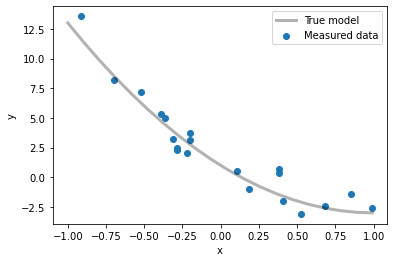

In [47]:
plot_measurments(1)

for $\alpha$ = 0, the gaussian mixtrue pull all its values from the Laplacian distribtion. An since $\beta$ changes the shape of the Laplacian distribtion as $\beta$ increases, so does the noise. Since the noise increases the paramter d will also increase.

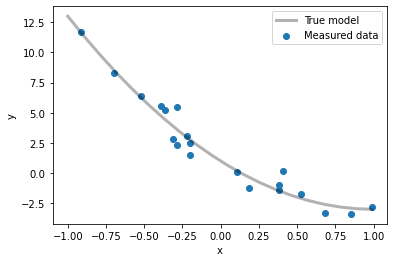

In [48]:
plot_measurments(1)

$\alpha$ = $\beta$= 1. As one increases $\alpha$ the gaussian mixture will weight the gaussian values more than the laplassian values. Since the gaussian distribtuion is wider and more spread out, the noise will increase and thus also the parameter d